# Урок 5. Случайный лес

### 1) Формирования выборки - bootstrap
![img/bootstrap.jpg](img/bootstrap.jpg)


### 2) Построение композиции алгоритмов - bagging
![img/bagging.png](img/bagging.png)  


### Random Forest == bagging на решающих деревьях

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

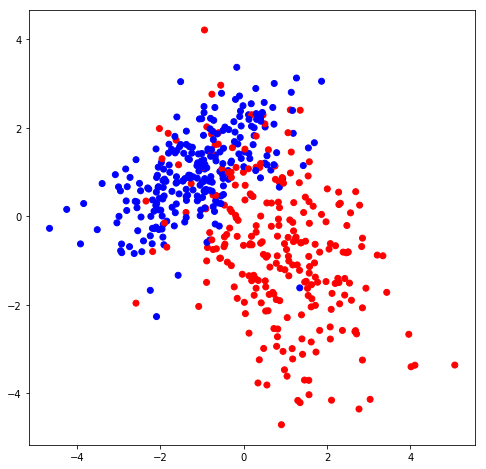

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

Повторим реализацию построения дерева решений из предыдущего урока

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [6]:
random.seed(42)

def get_bootstrap(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # TODO: random.choice()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [7]:
def get_bootstrap_OOB(N_labels, N_trees):
    """Функция формирует индексы сэмплов, которые войдут а bootstrap: in_bag_idx
    и которые не вошли - out_bag_idx"""
    full_idx = np.arange(0, N_labels, 1) 
    bootstrap = []
    
    for i in range(N_trees):
        in_bag_idx = np.random.choice(full_idx, full_idx.shape[0])
        out_bag_idx = []
        
        for i in full_idx:
            if i not in in_bag_idx:
                out_bag_idx.append(i)
        out_bag_idx = np.array(out_bag_idx)
        bootstrap.append((in_bag_idx, out_bag_idx))

    return bootstrap

In [8]:
def get_subsample(len_sample):
    
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for i in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет энтрипии Шеннона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    #impurity = 1
    H = 0
    for label in classes:
        p = classes[label] / len(labels)
        #impurity -= p ** 2
        H -= p * np.log2(p)
        
    return H

In [11]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    
    #return current_gini - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [12]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf=1):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels, min_leaf=1)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [15]:
def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [16]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Предсказание голосованием деревьев

In [18]:
from scipy.stats import mode

In [19]:
def tree_vote(forest, data):
    
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
        
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(mode(obj)[0][0])
    
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее.

In [20]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [21]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Тест самописного случайного леса

In [22]:
n_trees = 3

In [23]:
%%time
n_trees = 1


Wall time: 0 ns


In [24]:
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [25]:
train_answs = tree_vote(my_forest_1, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 97.143


In [26]:
test_answs = tree_vote(my_forest_1, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 94.000


In [27]:
%%time
n_trees = 3


Wall time: 0 ns


In [28]:
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [29]:
train_answs = tree_vote(my_forest_3, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 97.714


In [30]:
test_answs = tree_vote(my_forest_3, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 92.667


In [31]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 3.77 s


In [32]:
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [33]:
train_answs = tree_vote(my_forest_10, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 98.000


In [34]:
test_answs = tree_vote(my_forest_10, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 89.333


In [35]:
%%time
n_trees = 30


Wall time: 0 ns


In [36]:
my_forest_30 = random_forest(train_data, train_labels, n_trees)

In [37]:
train_answs = tree_vote(my_forest_30, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 96.571


In [38]:
test_answs = tree_vote(my_forest_30, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 89.333


In [39]:
%%time
n_trees = 50


Wall time: 0 ns


In [40]:
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [41]:
train_answs = tree_vote(my_forest_50, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 99.429


In [42]:
test_answs = tree_vote(my_forest_50, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 92.000


### Домашнее задание  
1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать  
 их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).  
   Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем (*).  
2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.  
3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*).  

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем (*).

In [43]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

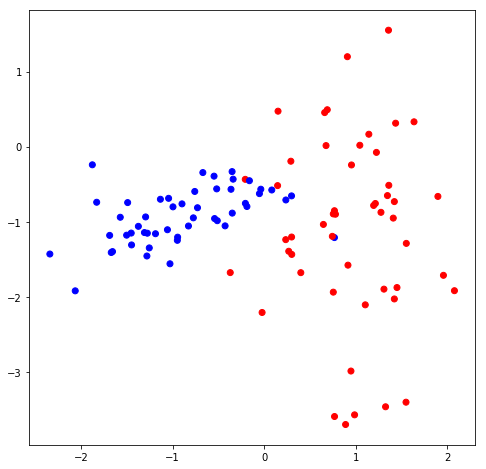

In [44]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [45]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [46]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [47]:
my_forest_1 = random_forest(train_data, train_labels, n_trees=1)

In [48]:
train_answs = tree_vote(my_forest_1, train_data)

In [49]:
test_answs = tree_vote(my_forest_1, test_data)

In [50]:
test_acc = accuracy_metric(test_labels, test_answs)

In [51]:
train_acc = accuracy_metric(train_labels, train_answs)

Text(0.5, 1.0, 'Test accuracy=80.00')

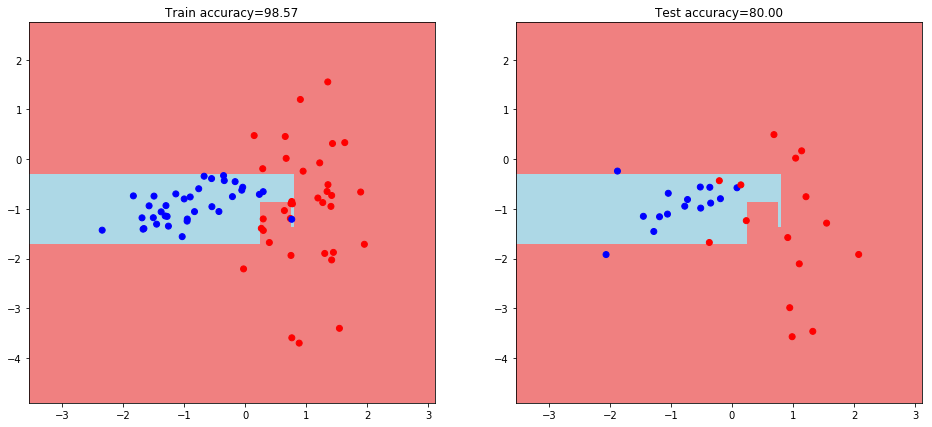

In [52]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [53]:
my_forest_3 = random_forest(train_data, train_labels, n_trees=3)

In [54]:
train_answs = tree_vote(my_forest_3, train_data)
test_answs = tree_vote(my_forest_3, test_data)
test_acc = accuracy_metric(test_labels, test_answs)
train_acc = accuracy_metric(train_labels, train_answs)

Text(0.5, 1.0, 'Test accuracy=86.67')

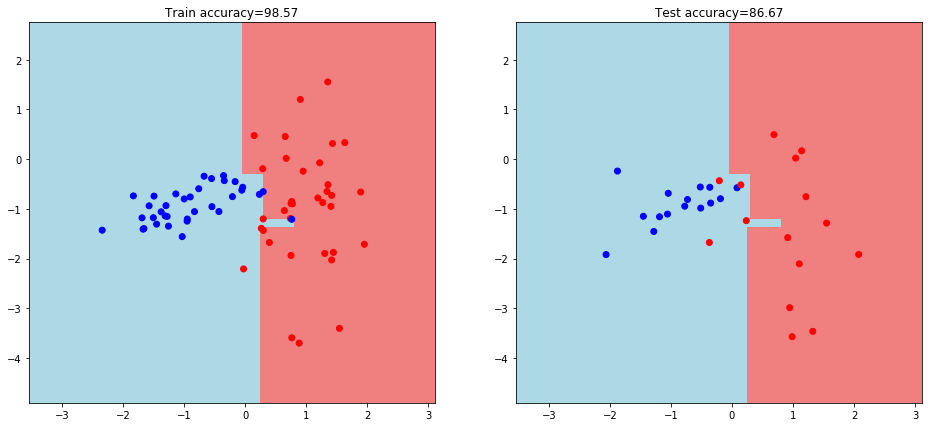

In [55]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [56]:
my_forest_10 = random_forest(train_data, train_labels, n_trees=10)

In [57]:
train_answs = tree_vote(my_forest_10, train_data)
test_answs = tree_vote(my_forest_10, test_data)
test_acc = accuracy_metric(test_labels, test_answs)
train_acc = accuracy_metric(train_labels, train_answs)

Text(0.5, 1.0, 'Test accuracy=83.33')

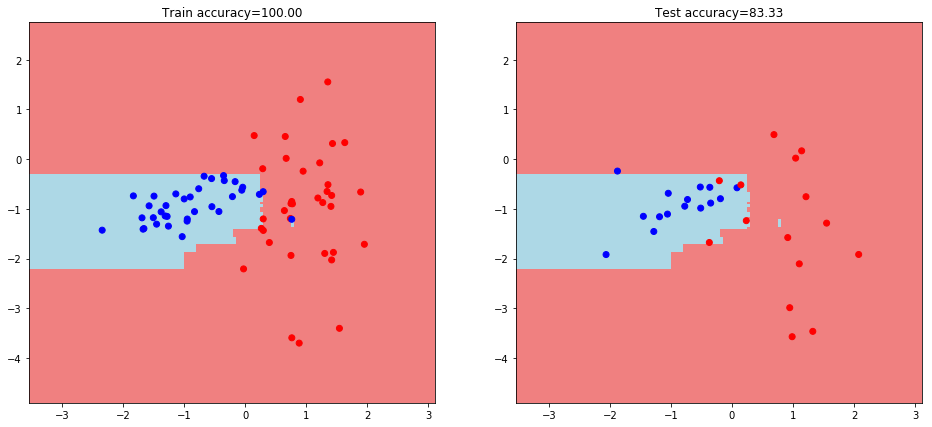

In [58]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [59]:
my_forest_50 = random_forest(train_data, train_labels, n_trees=50)

In [60]:
train_answs = tree_vote(my_forest_50, train_data)
test_answs = tree_vote(my_forest_50, test_data)
test_acc = accuracy_metric(test_labels, test_answs)
train_acc = accuracy_metric(train_labels, train_answs)

Text(0.5, 1.0, 'Test accuracy=86.67')

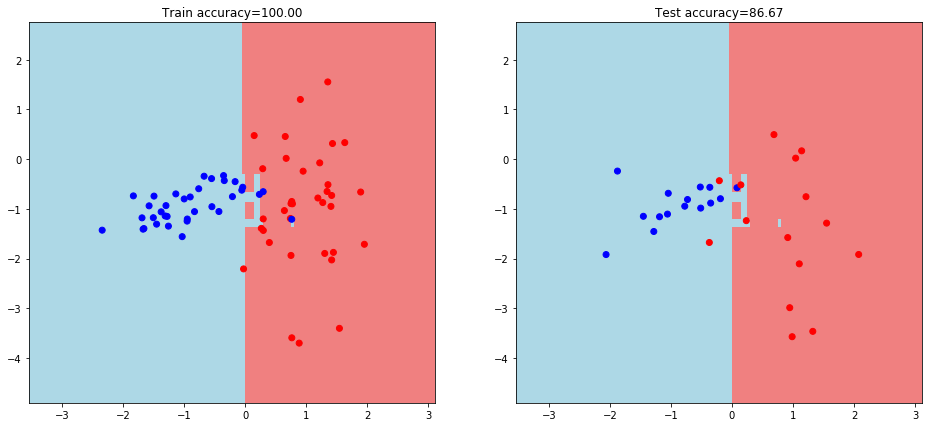

In [61]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Увеличение количества деревьев в лесу уменьнает переобучение, граница принятия решения становится более плавной.

### 2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.  

In [62]:
def random_forest_OOB(data, labels, n_trees):
    
    forest = []
    res = []
    # results - массив размера n_trees x len(labels). Хранит предсказания
    # для каждого дерева на OOB подвыборках (для каждого дерева своя). Пустые значения заполним 0.5 (для np.mean()),
    # чтобы в итоговом голосовании это не сказалось на результате, так как каждое дерево сделает
    # предсказание только на трети данных
    results = np.full((n_trees, len(labels)), 0.5)
    # В bootstrap для каждого дерева хранится пара - бутстрэп подвыборка и индексы тех записей,
    # которые не вошли в бутстрэп подвыборку 
    bootstrap = get_bootstrap_OOB(len(labels), n_trees)
    print("Вывод для каждого дерева bootstrap и OOB подвыборок")
    print(bootstrap)
    # Обучаем каждое дерево на бутстрэп подвыборке и проверяем на OOB
    cnt = 0
    for item in bootstrap:
        tree = build_tree(data[item[0]], labels[item[0]])
        result = predict(data[item[1]], tree)
        results[cnt][item[1]] = result
        forest.append(tree)
        cnt += 1
    print(results.T)
    for votes in results.T:
        result = votes.mean()
        # Если ни одно дерево не предсказывало для данного sample, то заменяем на nan
        if result == 0.5:
            result = np.nan
        res.append(np.around(result))
    res = np.array(res)
    labels = np.array(labels)
    print(res)
    print(res[~np.isnan(res)])
    print(labels)
    print(labels[~np.isnan(res)])
    OOB_acc = accuracy_metric(res[~np.isnan(res)], labels[~np.isnan(res)])
    
    #print(np.around(res))
    return forest, OOB_acc

In [63]:
def get_bootstrap_OOB(N_labels, N_trees):
    """Функция формирует индексы сэмплов, которые войдут а bootstrap: in_bag_idx
    и которые не вошли - out_bag_idx"""
    full_idx = np.arange(0, N_labels, 1) 
    bootstrap = []
    
    for i in range(N_trees):
        in_bag_idx = np.random.choice(full_idx, full_idx.shape[0])
        out_bag_idx = []
        
        for i in full_idx:
            if i not in in_bag_idx:
                out_bag_idx.append(i)
        out_bag_idx = np.array(out_bag_idx)
        bootstrap.append((in_bag_idx, out_bag_idx))

    return bootstrap

In [64]:
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [65]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [66]:
my_forest_OOB, OOB_accuracy = random_forest_OOB(train_data, train_labels, n_trees=10)

Вывод для каждого дерева bootstrap и OOB подвыборок
[(array([135, 179,  40, 197, 294, 344,  52, 348, 160, 324,  42, 259, 168,
       288,  82, 308, 181, 319,  93, 201,  87, 249, 114, 117, 299, 326,
        42, 282, 182, 301,  48, 155, 141, 140, 324,  18,  11, 313,  14,
       286, 122, 252, 247,  84,  97,  71,  93, 189, 105, 279, 146, 144,
       312, 101,  85,  76, 334, 137, 178, 173, 250, 131, 167, 306, 135,
       343,  55, 279, 171,  55, 108, 110, 230, 140,  17, 315, 170,  46,
       151,  14, 258, 287, 121, 131, 244, 319, 124,  30, 314, 149, 267,
       171,  17,  53,  73, 320, 113, 310, 128, 192, 307, 281,  83,  13,
         4, 174, 164, 204, 197,  69,  56,  24,  99, 292, 203, 324, 160,
       238, 163, 112, 103, 349,  80, 305, 254, 328, 155,  32,  47, 187,
        33, 131, 313,  40, 338,  33, 261, 297, 131, 110,  99, 344,  41,
       208,  34,  76, 123,  69,  55, 117, 246, 259,  30,  12,  83, 295,
       177, 157, 187, 157, 173,  93,  12, 299, 128, 198, 229, 289, 232,
        17

[[1.  1.  0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 1.  1.  0.5]
 [0.  0.  0.5 ... 0.5 0.5 0.5]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.5 1.  1.  ... 0.5 1.  1. ]
 [0.5 0.  0.  ... 0.5 0.5 0. ]]
[ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  1.  1.  0.  1.  0.  1.  0.  1.  0. nan  0.  1.  0.  0.  1.  1.  1.  1.
  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.
  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  0.  0.  1. nan  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  0.  0.  0.  1.  0. nan  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1. nan  1.  0.  0.  1.
 nan  1. nan  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.
  1.  1.  0.  1.  0.  1.  0. nan nan  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  0.  0.  0.  1.  1.  0.  1. nan  0.  1.  1.  0.  0.  1.  0.  0.  0.
  1. 

In [67]:
train_answs = tree_vote(my_forest_OOB, train_data)
test_answs = tree_vote(my_forest_OOB, test_data)
test_acc = accuracy_metric(test_labels, test_answs)
train_acc = accuracy_metric(train_labels, train_answs)

Text(0.5, 1.0, 'Test accuracy=94.67')

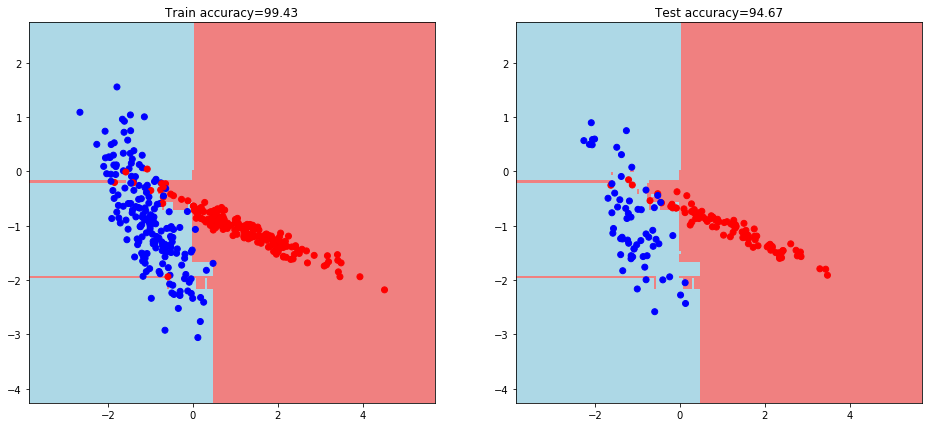

In [68]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_OOB, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

OOB_accuracy более точная, чем accuracy на Train и ближе к Test

In [69]:
OOB_accuracy

94.27710843373494

### 3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*). 

In [70]:
# Расчет энтрипии Шеннона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    #impurity = 1
    H = 0
    for label in classes:
        p = classes[label] / len(labels)
        #impurity -= p ** 2
        H -= p * np.log2(p)
        
    return H

In [71]:
a = [1, 1, 1, 1]

In [72]:
b = [2, 2, 1, 1]

In [73]:
c = [1, 1, 1, 2]

In [74]:
calc_entropy(a)

0.0

In [75]:
calc_entropy(b)

1.0

In [76]:
calc_entropy(c)

0.8112781244591328